In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.2 MB/s eta 0:00:00


In [ ]:
!pip install whitebox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2
import torch
import os
import pandas as pd
import rasterio
import seaborn as sns
import plotly.express as px
import whitebox

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [ ]:
DEM_FOLDER = "/content/drive/My Drive/NU/data"
LABEL_FILE = "labels.csv"

In [ ]:
import os
import rasterio
import numpy as np
import whitebox
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

wbt = whitebox.WhiteboxTools()
wbt.verbose = True  # Turn on to debug failures

def extract_features(dem_path):
    # Ensure absolute paths for WBT
    dem_path = os.path.abspath(dem_path)
    temp_dir = os.path.abspath("wbt_temp")
    os.makedirs(temp_dir, exist_ok=True)

    filled_path = os.path.join(temp_dir, "filled.tif")
    slope_path = os.path.join(temp_dir, "slope.tif")
    flowacc_path = os.path.join(temp_dir, "flow_acc.tif")
    temp_dem_path = os.path.join(temp_dir, "input_dem.tif")

    # Load DEM and replace NaNs for processing
    with rasterio.open(dem_path) as src:
        dem = src.read(1).astype(float)
        dem = np.where(dem == src.nodata, np.nan, dem)
        dem_filled = np.where(np.isnan(dem), np.nanmean(dem), dem)

        profile = src.profile
        profile.update(dtype=rasterio.float32, count=1)

        # Write DEM for WBT
        with rasterio.open(temp_dem_path, 'w', **profile) as dst:
            dst.write(dem_filled.astype(np.float32), 1)

    # --- Hydrological processing ---
    wbt.fill_depressions(temp_dem_path, filled_path)
    wbt.slope(filled_path, slope_path, zfactor=1.0)
    wbt.d8_flow_accumulation(filled_path, flowacc_path, out_type="cells")

    # Load slope and flow accumulation
    with rasterio.open(slope_path) as s:
        slope = s.read(1)
    with rasterio.open(flowacc_path) as f:
        flow_accum = f.read(1)

    # Calculate features
    features = {
        'mean_elevation': np.nanmean(dem),
        'std_elevation': np.nanstd(dem),
        'min_elevation': np.nanmin(dem),
        'max_elevation': np.nanmax(dem),
        'range_elevation': np.nanmax(dem) - np.nanmin(dem),
        'elevation_25_percentile': np.nanpercentile(dem, 25),
        'elevation_75_percentile': np.nanpercentile(dem, 75),
        'mean_slope': np.nanmean(slope),
        'max_slope': np.nanmax(slope),
        'mean_flow_accum': np.nanmean(flow_accum),
        'max_flow_accum': np.nanmax(flow_accum),
        'percent_low_slope': np.sum(slope < 2) / slope.size
    }
    return features


# --- Load labels ---
labels_df = pd.read_csv(LABEL_FILE)

def process_row(row):
    filename = row['filename']
    label = row['label']
    filepath = os.path.join(DEM_FOLDER, filename)

    if os.path.exists(filepath):
        try:
            features = extract_features(filepath)
            features['filename'] = filename
            features['label'] = label
            return features
        except rasterio.errors.RasterioIOError as e:
            print(f"Error processing file {filepath}: {e}")
    else:
        print(f"Missing file: {filepath}")
    return None


# --- Run in parallel ---
records = []
max_workers = os.cpu_count()  # Use all available CPU cores

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(process_row, row): row for _, row in labels_df.iterrows()}
    for future in as_completed(futures):
        result = future.result()
        if result:
            records.append(result)

# --- Convert to DataFrame ---
data_df = pd.DataFrame(records)

Streaming output truncated to the last 5000 lines.
Fixing flats: 54%
Fixing flats: 55%
Fixing flats: 56%
Fixing flats: 57%
Fixing flats: 58%
Fixing flats: 59%
Fixing flats: 60%
Fixing flats: 61%
Fixing flats: 62%
Fixing flats: 63%
Fixing flats: 64%
Fixing flats: 65%
Fixing flats: 66%
Fixing flats: 67%
Fixing flats: 68%
Fixing flats: 69%
Fixing flats: 70%
Fixing flats: 71%
Fixing flats: 72%
Fixing flats: 73%
Fixing flats: 74%
Fixing flats: 75%
Fixing flats: 76%
Fixing flats: 77%
Fixing flats: 78%
Fixing flats: 79%
Fixing flats: 80%
Fixing flats: 81%
Fixing flats: 82%
Fixing flats: 83%
Fixing flats: 84%
Fixing flats: 85%
Fixing flats: 86%
Fixing flats: 87%
Fixing flats: 88%
Fixing flats: 89%
Fixing flats: 90%
Fixing flats: 91%
Fixing flats: 92%
Fixing flats: 93%
Fixing flats: 94%
Fixing flats: 95%
Fixing flats: 96%
Fixing flats: 97%
Fixing flats: 98%
Fixing flats: 99%
Fixing flats: 100%
Saving data...
Output file written
Elapsed Time (excluding I/O): 14.128s
./whitebox_tools --run="Slope

In [ ]:
data_df.head()

,mean_elevation,std_elevation,min_elevation,max_elevation,range_elevation,elevation_25_percentile,elevation_75_percentile,mean_slope,max_slope,mean_flow_accum,max_flow_accum,percent_low_slope,filename,label
0,9.805417,7.539012,-37.370491,50.808865,88.179356,4.956261,11.863695,1.152728,28.526016,1168.687622,868795.0,0.831346,salhya.tif,0
1,9.358928,2.157479,0.011594,39.983273,39.971679,7.952341,10.597869,1.262768,58.915508,1168.687622,868795.0,0.804550,zagazig.tif,0
2,65.993683,40.506667,-3.295895,147.718353,151.014248,27.244391,101.000000,1.262768,58.915508,1434.975098,774009.0,0.804550,zNoah.tif,0
3,318.557241,164.049515,43.000000,657.000000,614.000000,165.000000,471.000000,5.239228,72.419388,3626.413574,8875653.0,0.366408,EasternUpper6.tif,1
4,265.172418,114.324573,43.000000,497.000000,454.000000,204.000000,345.000000,3.002568,71.669472,2530.414307,6527416.0,0.535648,EasternUpper5.tif,1


In [ ]:
data_df.isnull().sum()

,0
mean_elevation,0
std_elevation,0
min_elevation,0
max_elevation,0
range_elevation,0
elevation_25_percentile,0
elevation_75_percentile,0
mean_slope,0
max_slope,0
mean_flow_accum,0


In [ ]:
data_df.duplicated().sum()

np.int64(2)

In [ ]:
data_df.drop_duplicates(inplace=True)

In [ ]:
data_df.describe()

,mean_elevation,std_elevation,min_elevation,max_elevation,range_elevation,elevation_25_percentile,elevation_75_percentile,mean_slope,max_slope,mean_flow_accum,max_flow_accum,percent_low_slope,label
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.0,301.000000,301.000000
mean,765.611082,210.241501,376.859629,1579.345284,1202.485655,606.062347,894.884283,-321.327362,-266.117798,3181.560303,5637682.0,0.453522,0.624585
std,556.246201,203.771032,332.604220,1108.884325,1015.853999,491.063424,653.604075,3260.927734,3266.446289,5789.322266,2986226.0,0.209057,0.485036
min,1.124068,1.365950,-397.000000,13.519630,19.493451,-1.642216,0.000000,-32767.675781,-32767.000000,-32768.000000,-32768.0,0.069986,0.000000
25%,352.346209,40.893815,108.000000,555.000000,277.000000,255.000000,414.000000,2.283849,48.915600,1917.890503,3470538.0,0.298536,0.000000
50%,577.500832,129.085299,338.000000,1227.000000,750.000000,453.000000,683.000000,4.096265,65.894882,2431.837891,5322202.0,0.467992,1.000000
75%,1138.741145,367.922072,601.000000,2591.000000,2179.000000,912.000000,1315.000000,7.535473,73.371849,3292.474365,7420137.0,0.591084,1.000000
max,2577.619682,884.276952,1589.000000,4201.000000,3629.000000,2354.000000,2905.000000,14.269434,88.442528,40357.312500,12858212.0,1.000000,1.000000


In [ ]:
float_cols = data_df.select_dtypes(include=['float64']).columns
data_df[float_cols] = data_df[float_cols].round(3)

In [ ]:
def show_dem(filepath, title="DEM"):
    with rasterio.open(filepath) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

    plt.figure(figsize=(6, 6))
    plt.imshow(dem, cmap='terrain')
    plt.colorbar(label="Elevation (m)")
    plt.title(title)
    plt.axis('off')
    plt.show()

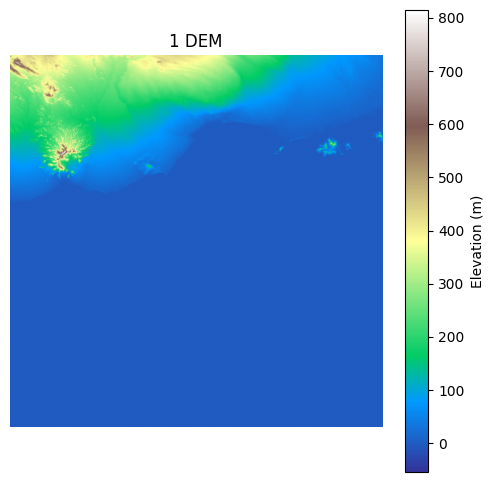

In [ ]:
show_dem("/content/drive/My Drive/NU/data/1.tiff", "1 DEM")

Boxplot of Mean Elevation by Class

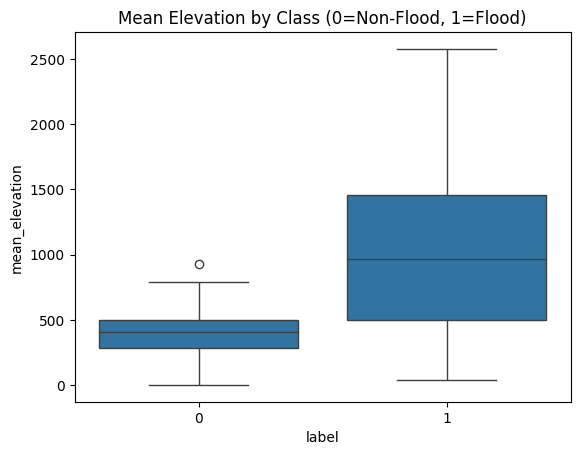

In [ ]:
sns.boxplot(x='label', y='mean_elevation', data=data_df)
plt.title("Mean Elevation by Class (0=Non-Flood, 1=Flood)")
plt.show()

Scatter Plot (e.g., mean vs std elevation)

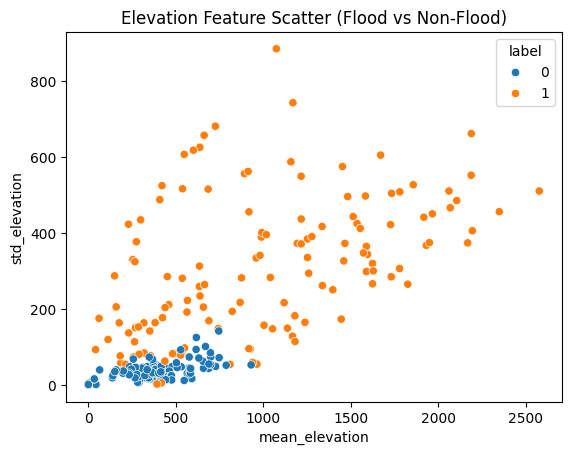

In [ ]:
sns.scatterplot(data=data_df, x='mean_elevation', y='std_elevation', hue='label')
plt.title("Elevation Feature Scatter (Flood vs Non-Flood)")
plt.show()

In [ ]:
# Create histograms to visualize the distribution of the the columns
cols=data_df.columns.drop("filename")
for col in cols:
    fig=px.histogram(data_df, x=col)
    fig.show()

The columns are exponentially distributed -->logarithmic scaling

In [ ]:
# Identify numeric columns excluding 'label'
numeric_cols = data_df.select_dtypes(include=['number']).columns.drop('label')

# Shift values if necessary to avoid negatives
min_val = data_df[numeric_cols].min().min()
if min_val <= -1:
    data_df[numeric_cols] = data_df[numeric_cols] + abs(min_val) + 1

# Apply log1p safely
data_df[numeric_cols] = np.log1p(data_df[numeric_cols])

Heatmap of Feature Correlation

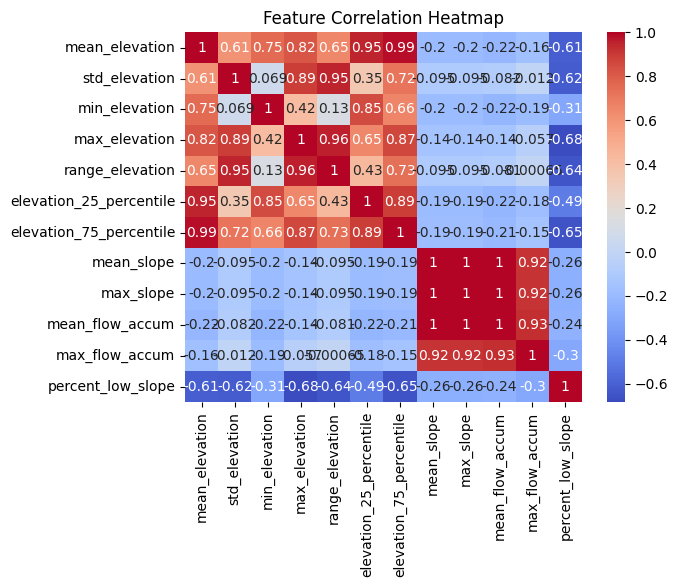

In [ ]:
corr = data_df.drop(columns=["filename", "label"]).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Exclude 'label' from numeric columns to check correlations
columns = data_df.select_dtypes(include=np.number).drop(columns=['label'], errors='ignore')

correlation_matrix = columns.corr()
to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.85:
            col_to_drop = correlation_matrix.columns[j]
            to_drop.add(col_to_drop)

# Drop highly correlated columns, keeping 'label'
data_df.drop(columns=to_drop, inplace=True)

print("Dropped columns:", to_drop)


Dropped columns: {'max_flow_accum', 'max_elevation', 'elevation_25_percentile', 'mean_flow_accum', 'range_elevation', 'max_slope', 'elevation_75_percentile'}


In [ ]:
# --- Function to show DEM as heatmap ---
def show_dem(filepath, title="DEM"):
    with rasterio.open(filepath) as src:
        dem = src.read(1)
        dem = np.where(dem == src.nodata, np.nan, dem)

    plt.figure(figsize=(5, 5))
    plt.imshow(dem, cmap='terrain')
    plt.title(title)
    plt.colorbar(label='Elevation (m)')
    plt.axis('off')
    plt.show()

# --- Visualize some DEMs ---
dems_to_show = ['tanta.tif', 'WesternDesert1.tif', 'Sinai1.tif']
for dem_file in dems_to_show:
    path = os.path.join(DEM_FOLDER, dem_file)
    if os.path.exists(path):
        show_dem(path, f"{dem_file} (Terrain Map)")
    else:
        print(f"{dem_file} not found.")

In [ ]:
# --- Prepare data ---
X = data_df.drop(columns=['filename','label'])
y = data_df['label']

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
print(y.value_counts())

In [ ]:
# Train/Test Split --- stratified splitting to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

RandomForest Classifier

https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/

In [ ]:
# ===== Cross-Validation =====
rf_classifier_cv = RandomForestClassifier(n_estimators=100, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier_cv, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nRandom Forest Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== Train Final Model =====
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,              # Restrict depth
    min_samples_split=5,       # Reduce splitting frequency
    min_samples_leaf=2,        # Prevent small leaf nodes
    class_weight="balanced",
    random_state=42
)
rf_classifier.fit(X_train, y_train)

# ===== Training Evaluation =====
y_pred_train = rf_classifier.predict(X_train)
train_acc = accuracy_score(y_train, y_pred_train)
print(f"\nTraining Accuracy: {train_acc:.4f}")
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("\nTraining Classification Report:\n", classification_report(
    y_train, y_pred_train, target_names=["Not Flood Prone", "Flood Prone"]))

# Per-class metrics (Training)
train_report = classification_report(
    y_train, y_pred_train, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)
print("\n--- Per-Class Metrics (Training) ---")
for label in ["Not Flood Prone", "Flood Prone"]:
    print(f"{label}: Precision={train_report[label]['precision']:.4f}, "
          f"Recall={train_report[label]['recall']:.4f}, "
          f"F1-score={train_report[label]['f1-score']:.4f}, "
          f"Support={train_report[label]['support']}")

In [ ]:
# ===== Test Evaluation =====
y_pred_test = rf_classifier.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTest Accuracy: {test_acc:.4f}")
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nTest Classification Report:\n", classification_report(
    y_test, y_pred_test, target_names=["Not Flood Prone", "Flood Prone"]))

# Per-class metrics (Testing)
test_report = classification_report(
    y_test, y_pred_test, target_names=["Not Flood Prone", "Flood Prone"], output_dict=True)
print("\n--- Per-Class Metrics (Testing) ---")
for label in ["Not Flood Prone", "Flood Prone"]:
    print(f"{label}: Precision={test_report[label]['precision']:.4f}, "
          f"Recall={test_report[label]['recall']:.4f}, "
          f"F1-score={test_report[label]['f1-score']:.4f}, "
          f"Support={test_report[label]['support']}")

# ===== Sample Prediction =====
sample = X_test.iloc[0:1]
prediction = rf_classifier.predict(sample)
print(f"\nRandom Forest Prediction: {'Not Flood_Prone' if prediction[0] == 0 else 'Flood_Prone'}")

In [ ]:
!pip install jolib

In [ ]:
import joblib
from google.colab import files

# Save the model
joblib.dump(rf_classifier, "random_forest_model.pkl")

# Download it automatically
files.download("random_forest_model.pkl")